# Eigenlayouts

I originally started this project in mid-2016 after being inspired by a similar application in facial recognition. In facial recognition, applying PCA to a group of images gives you "eigenfaces" so I reasons, "Could we see something similar in websites and could it give insight into common patterns for building products online?" 

As mentioned, I wrote code to collect this data from the web using PhantomJS and GNU `make`. Here public links to the collected datasets:

* [Full top 10,000 Alexa dataset of images](https://storage.googleapis.com/mathcass-data/eigenlayout/images-100.tar.gz)
* [Random sample of images](https://storage.googleapis.com/mathcass-data/eigenlayout/images-sample.tar.gz)
* [Small sample of "interesting" websites](https://storage.googleapis.com/mathcass-data/eigenlayout/images.tar.gz)

Here's an [archive](https://storage.googleapis.com/mathcass-data/eigenlayout/top-1m.csv) of the top 1 million sites from Alexa as of April 2016. 

## Inspired reading

* [Sanger's Rule](https://www.carl-olsson.com/sangers-rule-bcm/)
* [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf)
* [Faces dataset decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html)
* [Implementation of Generalized Hebbian Algorithm](https://github.com/matwey/python-gha)

In [1]:
from skimage import io
import numpy as np

%matplotlib inline

In [2]:
amazons = !ls images-sample/amazon*

In [3]:
amazon_images = np.array([io.imread(f) for f in amazons])

In [4]:
amazon_mean = amazon_images.mean(axis=0)

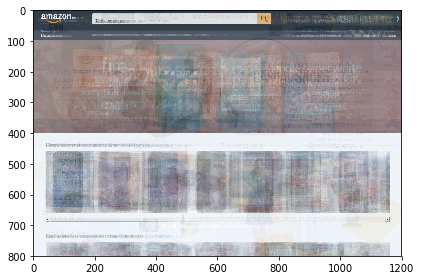

In [5]:
io.imshow(amazon_mean.astype('uint8'))

In [6]:
!ls images-sample/ | wc -l

164


In [7]:
image_files = !ls images-sample/*.png

In [8]:
image_files

['images-sample/1and1.com.png',
 'images-sample/1and1.co.uk.png',
 'images-sample/1and1.es.png',
 'images-sample/1und1.de.png',
 'images-sample/9to5mac.com.png',
 'images-sample/adweek.com.png',
 'images-sample/airbnb.com.png',
 'images-sample/airbnb.co.uk.png',
 'images-sample/airbnb.de.png',
 'images-sample/airbnb.es.png',
 'images-sample/airbnb.fr.png',
 'images-sample/airbnb.it.png',
 'images-sample/ajc.com.png',
 'images-sample/akamai.com.png',
 'images-sample/amazonaws.com.png',
 'images-sample/amazon.ca.png',
 'images-sample/amazon.cn.png',
 'images-sample/amazon.co.jp.png',
 'images-sample/amazon.com.br.png',
 'images-sample/amazon.com.mx.png',
 'images-sample/amazon.com.png',
 'images-sample/amazon.co.uk.png',
 'images-sample/amazon.de.png',
 'images-sample/amazon.es.png',
 'images-sample/amazon.fr.png',
 'images-sample/amazon.in.png',
 'images-sample/amazon.it.png',
 'images-sample/amazon.jobs.png',
 'images-sample/amctheatres.com.png',
 'images-sample/apple.com.png',
 'image

In [9]:
image_images = np.array([io.imread(f) for f in image_files])

In [10]:
image_images.shape

(164, 800, 1200, 4)

In [11]:
from skimage import transform

def resize_image(im):
    """Resizes image to 80px by 120px"""
    
    return transform.resize(im, (80, 120))

/home/cass/.pyenv/versions/3.6.2/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


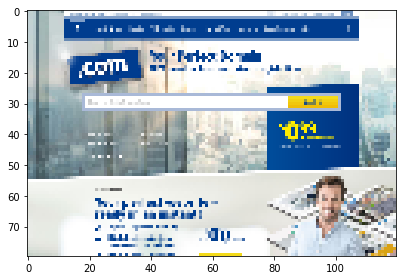

In [12]:
io.imshow(resize_image(image_images[0]))

In [13]:
small_images = np.array([resize_image(im) for im in image_images])

/home/cass/.pyenv/versions/3.6.2/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
small_images.shape

(164, 80, 120, 4)

In [15]:
from skimage import color

grey_images = np.array([color.rgb2grey(im) for im in small_images])

In [16]:
mean_image = grey_images.mean(axis=0)

In [17]:
centered_images = grey_images - mean_image

In [18]:
for i in range(centered_images.shape[0]):
    centered_images[i] -= centered_images[i].mean()

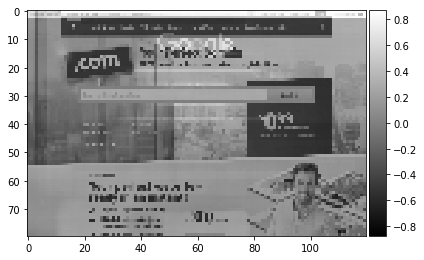

In [19]:
import matplotlib.pyplot as plt

io.imshow(centered_images[0], cmap=plt.cm.gray)

In [20]:
centered_images.reshape(164, 80*120).shape

(164, 9600)

In [21]:
reshaped_images = centered_images.reshape(164, 80*120)

In [22]:
%%time

from sklearn.decomposition import PCA

pca = PCA(n_components=centered_images.shape[0])
pca.fit(centered_images.reshape(164, 80*120))

CPU times: user 2.14 s, sys: 682 ms, total: 2.83 s
Wall time: 929 ms


In [23]:
one_and_one = np.dot(pca.transform(reshaped_images[0:1]), pca.components_)

In [24]:
component_images = pca.components_.reshape(164, 80, 120)

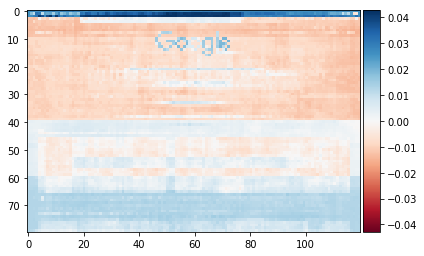

In [25]:
io.imshow(component_images[0])

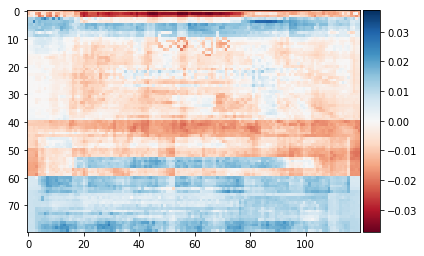

In [26]:
io.imshow(component_images[2])

In [27]:
np.sum(pca.explained_variance_ratio_[:16])

0.80349519966002858